In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xenu import full_path

## Flux data

From Haxton 2013 solar $\nu$ review paper 

In [2]:
# in units of cm^{-2} s^{-1}

# if model not stated, comes from Solar data

total_flux = dict(pp=6.05e10,
                  pep=1.46e8,
                  be7=4.82e9,
                  b8=5e6,
                  hep=8.04e3,  # GS98 model
                  n13=2.96e8,  # GS98 model
                  o15=2.23e8,  # GS98 model
                  f17=5.52e6   # GS98 model
                  )

diff_flux = {}

## Extract energy spectra

In [3]:
# pp 
Es = []
ps = []

with open(full_path('data/energy_spectra/pp.txt')) as f:
    data = f.read().split('\n\n')[-1].strip()
    E_indices = [0, 2, 4, 6]
    p_indices = [1, 3, 5, 7]
    for E_i, p_i in zip(E_indices, p_indices):
        for line in data.split('\n'):
            split = line.split()
            Es.append(float(split[E_i]))
            ps.append(float(split[p_i]))

Es = np.array(Es)
ps = np.array(ps)

flux = ps * total_flux['pp']
diff_flux['pp'] = dict(x=Es, y=flux)

In [4]:
# pep
# line source at 1.44 MeV

Es = np.linspace(0, 1.44*2, 101)
ps = np.zeros_like(Es)
ps[50] = 1

Es = np.array(Es)
ps = np.array(ps)

flux = ps * total_flux['pep']
diff_flux['pep'] = dict(x=Es, y=flux)

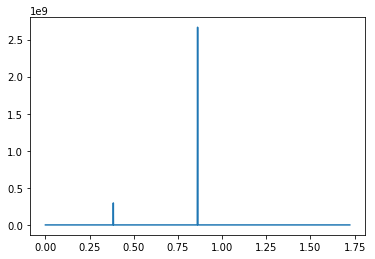

In [5]:
# beryllium-7
# two line sources at (1) 861.3 keV and (2) 384.3 keV

Es1 = np.linspace(0, 384.3*2, 1001)
ps1 = np.zeros_like(Es1)
ps1[500] = 1

Es2 = np.linspace(0, 861.3*2, 1001)
ps2 = np.zeros_like(Es1)
ps2[500] = 1

idx2 = np.where(Es2 > max(Es1))[0]
Es = np.hstack((Es1, Es2[idx2]))

ps = np.zeros_like(Es)
# include branching ratios -- see Haxton review (2013)
ps[:1001] = 0.1*ps1
ps[1001:] = 0.9*ps2[idx2]

# normalize
ps = ps / np.trapz(ps, Es)

# convert to MeV
Es = Es/1000
flux = total_flux['be7']*ps
diff_flux['be7'] = dict(x=Es, y=flux)

plt.plot(Es, flux)
plt.show()

In [6]:
# boron-8 
Es = []
ps = []

with open(full_path('data/energy_spectra/b8.txt')) as f:
    data = f.read().split('.....\n')[1].strip()
    for line in data.split('\n'):
        split = line.split()
        Es.append(float(split[0]))
        ps.append(float(split[1]))

Es = np.array(Es)
ps = np.array(ps)

flux = ps * total_flux['b8']
diff_flux['b8'] = dict(x=Es, y=flux)

In [7]:
# hep
Es = []
ps = []

with open(full_path('data/energy_spectra/hep.txt')) as f:
    for line in f.readlines():
        split = line.split()
        Es.append(float(split[0]))
        ps.append(float(split[1]))

Es = np.array(Es)
ps = np.array(ps)

flux = ps * total_flux['hep']
diff_flux['hep'] = dict(x=Es, y=flux)

In [9]:
# CNO

for cno in ['n13', 'o15', 'f17']:
    Es = []
    ps = []
    with open(full_path('data/energy_spectra/%s.txt' % cno)) as f:
        for line in f.readlines():
            split = line.split()
            Es.append(float(split[0]))
            ps.append(float(split[1]))

    Es = np.array(Es)
    ps = np.array(ps)
    flux = ps * total_flux[cno]
    diff_flux[cno] = dict(x=Es, y=flux)


## Plot flux

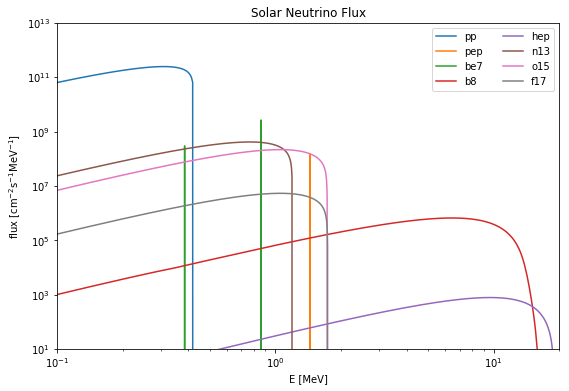

In [10]:
plt.figure(figsize=(9,6))
for label, flux in diff_flux.items():
    plt.plot(flux['x'], flux['y'], label=label)
plt.xlabel("E [MeV]")
plt.ylabel("flux [cm$^{-2}$s$^{-1}$MeV$^{-1}$]")
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 20)
plt.ylim(10, 1e13)
plt.legend(ncol=2)
plt.title("Solar Neutrino Flux")
plt.savefig('solarnu_flux.pdf')
plt.show()

In [12]:
import pickle

with open(full_path('data/solarnu_flux.pkl'), 'wb') as f:
    pickle.dump(diff_flux, f)

## Dump flux data to disk

In [13]:
# just dump the data points for the continuous spectra
# save the E, flux single points for the lines
import os

fluxdir = full_path('data/flux_data')
os.makedirs(fluxdir, exist_ok=True)

lines = dict(pep=[1.44], be7=[0.3843, 0.8613])

for label, flux in diff_flux.items():
    if label in lines:
        with open(os.path.join(fluxdir, '%s.csv' % label), 'w') as f:
            f.write('E,flux\n')
            for line in lines[label]:
                x = line
                y = flux['y'][np.where(np.absolute(flux['x']-x) < 1e-8)][0]
                f.write('%f,%f\n' % (x, y))
    else:
        with open(os.path.join(fluxdir, '%s.csv' % label), 'w') as f:
            f.write('E,flux\n')
            for x, y in zip(flux['x'], flux['y']):
                f.write('%f,%f\n' % (x, y))